In [1]:
%matplotlib inline
import matplotlib

In [2]:
import csv
import numpy as np
import pandas as pd
matplotlib.style.use('seaborn')
import matplotlib.pyplot as plt
from copy import deepcopy
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot

In [3]:
cubic = ["W","V","K","Al","Cu","Pd"]
hcp = ["Ti","Re","Y"]
metals = cubic+hcp

In [6]:
def get_mean_data_kpd(method,elements,sub_method=None):
    """Gathers the convergence data for the given method, element, 
    and sub-method, i.e. 'sc' for the Froyen method, and places it
    in a pandas dataframe where each column is a different cell 
    size and each row is a different k-point density. The dataframe also
    contains the mean error per density and numbder of instances 
    the density occures.
    
    Args:
        methad (str): "Froyen", "Mueller", or "Aflow"
        elements (list of str): A list consisting of the desired 
            elements ("V", "W", "Cu", "Al", "K", "Pd", "Ti", "Y", "Re")
        sub_method (str, optional): The sampling scheme for the 
            Froyen method ("sc", "bcc", "fcc", "hcp"). A sub_method is
            required for the Froyen method and for any other method
            this should be None.
    
    Returns:
        outdf (pandas.dataframe): A pandas dataframe of the error in
            the calculated energy at each density (row) and supercell 
            (column) in addition to a column of the average error per
            density.
    """
    c_v = {"Al":3.7436520909,"W":13.011266364,"Ti":15.504992857,'Cu':3.719485,'K':1.02714,
           'Pd':5.178934,'Re':24.815031429,'V':8.9434335455,'Y':12.893802}
    for el in elements:
        cv = c_v[el]
        if el in ["Ti","Y","Re"]:
            sizes = range(1,8)
        else:
            sizes = range(1,12)
            
        for i in sizes:
            data = []
            kpd = []
            if sub_method is None:
                f = open("../data2/{0}/{1}_conv/{2}_atom_kpd_conv.csv".format(method,el,i),"r")
            else:
                f = open("../data2/{0}_VASP/{1}_conv/{2}_{3}_atom_kpd_conv.csv".format(method,el,i,sub_method),"r")
            reader = csv.reader(f,delimiter='\t')
            for row in reader:
                if el in ["Ti","Re","Y"]:
                    if float(row[0]) in kpd and float(row[1]) != 0:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+(float(row[1])/cv)/2.)/2.
                    elif float(row[1]) != 0:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),(float(row[1])/cv)/2.]
                        data.append(point)                    
                else:
                    if float(row[0]) in kpd and float(row[1]) != 0:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+(float(row[1])/(cv/2.)))/2.
                    elif float(row[1]) != 0:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),float(row[1])/(cv/2.)]
                        data.append(point)
                    
            data = np.array(data)
            if len(data) >= 1:
                df = pd.DataFrame(data[:,1:],index=data[:,0])#,columns=[str(i)+' atom'])    
            else:
                print("Method: {0}, element: {1}, size: {2}".format(method,el,i))
                
            if i > 1 or el != elements[0]:
                outdf = pd.concat([outdf,df], axis=1)
            else:
                outdf = df

    outdf['mean'] = outdf.mean(axis=1) 
    outdf['count'] = outdf.apply(lambda x: x.count(), axis=1)
    return outdf

In [7]:
M_metals = get_mean_data_kpd("Mueller",metals)
F_sc_metals = get_mean_data_kpd("Froyen",["W","V","K","Al","Cu","Pd"],sub_method="sc")
F_bcc_metals = get_mean_data_kpd("Froyen",["W","V","K","Al","Cu","Pd"],sub_method="bcc")
F_fcc_metals = get_mean_data_kpd("Froyen",["W","V","K","Al","Cu","Pd"],sub_method="fcc")
F_hcp_metals = get_mean_data_kpd("Froyen",["Ti","Re","Y"],sub_method="hcp")
A_metals = get_mean_data_kpd("Aflow",metals)

Method: Froyen, element: V, size: 1
Method: Froyen, element: V, size: 1


In [11]:
M_mean = np.transpose([M_metals.index.values,M_metals["mean"]])
A_mean = np.transpose([A_metals.index.values,A_metals["mean"]])
F_sc_mean = np.transpose([F_sc_metals.index.values,F_sc_metals["mean"]])
F_bcc_mean = np.transpose([F_bcc_metals.index.values,F_bcc_metals["mean"]])
F_fcc_mean = np.transpose([F_fcc_metals.index.values,F_fcc_metals["mean"]])
F_hcp_mean = np.transpose([F_hcp_metals.index.values,F_hcp_metals["mean"]])

In [18]:
F_mean = np.concatenate((F_sc_mean,F_bcc_mean),axis=0)
F_mean = np.concatenate((F_mean,F_fcc_mean),axis=0)
F_mean = np.concatenate((F_mean,F_hcp_mean),axis=0)

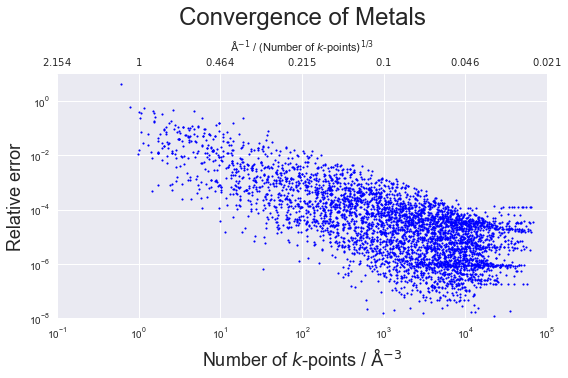

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
 
ax1.scatter(M_mean[:,0],abs(M_mean[:,1]),label="General",marker="o",s=3,c='b')
ax1.set_xlabel("Number of $k$-points / $\mathrm{\AA}^{-3}$",fontsize=18)
ax1.set_xscale('log')

new_tick_locations = np.array([.1,1,10,100,1000,10000,100000])
def tick_function(X):
    V = 1/X
    return [np.log10(z) for z in V]
ax1.set_xlim(.1,100000)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xlabel("$\mathrm{\AA}^{-1}$ / (Number of $k$-points$)^{1/3}$")
ax2.set_xscale('log')
ax2.set_xticklabels(["$1.00$","$2.154$","$1$","$0.464$",
                    "$0.215$","$0.1$","$0.046$","$0.021$"])
ax2.grid(False)
ax1.set_ylabel("Relative error",fontsize=18)
plt.title("Convergence of Metals",fontsize=24,y=1.18)
plt.yscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.legend()
plt.tight_layout()
#plt.savefig("../plots/Mueller_metals_comb.pdf")
plt.show()

In [17]:
F_mean.shape

(953, 2)

In [1]:
import numpy as np

In [11]:
temp = np.array([4,4,7,6,7,7])

In [12]:
u_atoms = np.unique(temp)

In [14]:
atm_types = []
for i in temp:
    atm_types.append(np.where(u_atoms==i)[0][0])    

In [15]:
atm_types

[0, 0, 2, 1, 2, 2]

In [16]:
temp = [0,0,0]

In [19]:
np.shape(temp)[0]

3

In [20]:
eps = 1E-7

In [21]:
type(eps)

float

In [22]:
eps=np.float(eps)

In [23]:
type(eps)

float